https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download


# Read Data

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)

from src.recommend.utils.read import read_files

folder_path = "./data/kaggle_movies"
dataframes = read_files(folder_path)

credits = dataframes['credits']
keywords = dataframes['keywords']
links = dataframes['links']
links_small = dataframes['links_small']
movies_metadata = dataframes['movies_metadata']
ratings = dataframes['ratings']
ratings_small = dataframes['ratings_small']

movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
meta = movies_metadata.merge(links, left_on='id', right_on='tmdbId', how='left')
meta = meta[~meta['id'].isnull()]

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\utils\read.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


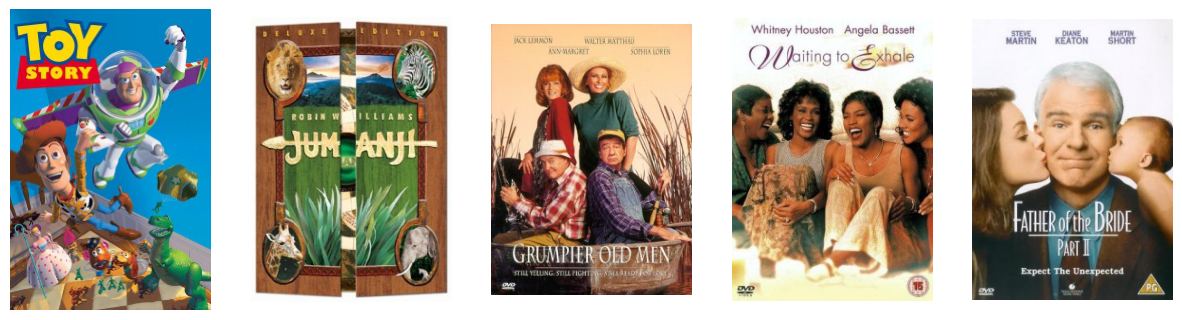

In [2]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from src.recommend.utils.image import image_url, show_image

# Fetch images
movie_list = movies_metadata['imdb_id'].head(5).values

images = image_url(movie_list)

show_image(images)

# Movies that a user watched
### Will generate recommendations based on this

In [8]:
def user_watched(ratings, user, top_n):
    temp = ratings[(ratings['userId'] == user)].sort_values(by='timestamp',ascending=False)[:top_n]
    movie_list = temp['movieId'].values
    return movie_list

movie_list = user_watched(ratings, 1, 20)
movie_list


array([73017, 91500, 98809, 91542,   147,  4226,  1968, 69844, 81834,
       58559, 33794, 99114,  2959,  2918,  1246,  1221,   110,   858,
       59315, 68358], dtype=int64)

# item-item recommendations with k-nn 
### Create user x movie matrix on ratings
**What movies were rated similarly by users?**

In [1]:
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import ast
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

class recommendation:
    def __init__(self, user, number, meta, ratings):
        self.user = user
        self.number = number
        self.meta = meta
        self.ratings = ratings 

    def user_watched(self, top_n):
        temp = self.ratings[(self.ratings['userId'] == self.user)].sort_values(by='timestamp',ascending=False)[:top_n]
        movie_list = temp['movieId'].values
        return movie_list

    def create_X(self):
        """
        Generates a sparse matrix from ratings dataframe.
        
        Args:
            ratings: pandas dataframe containing 3 columns (userId, movieId, rating)
        
        Returns:
            X: sparse matrix
            user_mapper: dict that maps user id's to user indices
            user_inv_mapper: dict that maps user indices to user id's
            movie_mapper: dict that maps movie id's to movie indices
            movie_inv_mapper: dict that maps movie indices to movie id's
        """
        # Number of unique users and movies to form matrix
        M = self.ratings['userId'].nunique()
        N = self.ratings['movieId'].nunique()

        # Map user/movie ID to an index (id, index)
        user_mapper = dict(zip(np.unique(self.ratings["userId"]), list(range(M))))
        movie_mapper = dict(zip(np.unique(self.ratings["movieId"]), list(range(N))))
        
        # Map an index to a user/movie ID (index,id)
        user_inv_mapper = dict(zip(list(range(M)), np.unique(self.ratings["userId"])))
        movie_inv_mapper = dict(zip(list(range(N)), np.unique(self.ratings["movieId"])))
        
        # list of unique indexes for users and movies
        user_index = [user_mapper[i] for i in self.ratings['userId']]
        item_index = [movie_mapper[i] for i in self.ratings['movieId']]

        
        X = csr_matrix((self.ratings["rating"], (user_index,item_index)), shape=(M,N))
        
        return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
    
    def find_similar_movies(self, movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine'):
        """
        Finds k-nearest neighbours for a given movie id.
        
        Args:
            movie_id: id of the movie of interest
            X: user-item utility matrix
            k: number of similar movies to retrieve
            metric: distance metric for kNN calculations
        
        Output: returns list of k similar movie ID's
        """
        # Now it is movie x user by transposing it.
        X = X.T
        neighbour_ids = []
        
        movie_ind = movie_mapper[movie_id]
        movie_vec = X[movie_ind]
        if isinstance(movie_vec, (np.ndarray)):
            movie_vec = movie_vec.reshape(1,-1)
        # use k+1 since kNN output includes the movieId of interest
        kNN = NearestNeighbors(n_neighbors=self.number+1, algorithm="brute", metric=metric)
        kNN.fit(X)
        neighbour = kNN.kneighbors(movie_vec, return_distance=False)
        for i in range(0,self.number):
            n = neighbour.item(i)
            neighbour_ids.append(movie_inv_mapper[n])
        neighbour_ids.pop(0)
        return neighbour_ids

    def genre_matrix(self):
        # Convert string representation of list to actual list
        try:
            self.meta["genres"] = self.meta["genres"].apply(ast.literal_eval)
        except:
            pass

        # Extract only the 'name' values
        self.meta["genres_list"] = self.meta["genres"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

        genres = set(g for G in self.meta["genres_list"] for g in G)
        df = self.meta[['movieId','genres_list']]

        for g in genres:
            df[g] = df.genres_list.transform(lambda x: int(g in x))

        df = df.reset_index(drop=True)
        movie_mapper = dict(zip(list(range(df.shape[0])), df["movieId"]))
        mapper_movie = dict(zip(df["movieId"], list(range(df.shape[0]))))
        movie_genres = df.drop(columns=['genres_list','movieId'])

        cosine_sim = cosine_similarity(movie_genres, movie_genres)

        return cosine_sim, movie_mapper, mapper_movie


    def genre_rec(self, matrix, movie_mapper, mapper_movie, movie):

        idx = mapper_movie[movie]

        sim_scores = list(enumerate(matrix[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:(self.number+1)]
        similar_movies = [movie_mapper[i[0]] for i in sim_scores]

        movie_list = self.meta[self.meta['movieId'].isin(similar_movies)]['imdb_id'].values

        return movie_list
    
    def similar_user_movies(self, user_num, user_movie, user_mapper, user_inv_mapper):

        similar_users = self.find_similar_movies(self.user, user_movie.T, user_mapper, user_inv_mapper, user_num)

        original_user_list = self.ratings[self.ratings['userId'] == 1]['movieId'].unique()

        similar_recommend = self.ratings[(self.ratings['userId'].isin(similar_users)) & (~self.ratings['movieId'].isin(original_user_list))]

        return similar_recommend

    def nb_mean(self, ratings):
        global_mean = ratings["rating"].mean()

        # Number of ratings per movie (n)
        movie_counts = ratings.groupby("movieId")["rating"].count()

        # Total rating sum per movie
        movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

        # C: Average number of ratings per movie
        C = movie_counts.mean()

        # Compute Bayesian Mean for each movie
        bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

        # Store results
        bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

        bayesian_mean_df = bayesian_mean_df.merge(self.meta[['movieId','title','imdb_id']], on='movieId',how='left')

        bayesian_mean_df = bayesian_mean_df.sort_values(by='bayesian_mean', ascending= False)

        return bayesian_mean_df

    def new_releases(self, date):
        # temp = merged_df[pd.to_datetime(merged_df['release_date']) >= pd.to_datetime('2017-07-01')][['movieId','release_date']].sort_values(by='release_date',ascending=False)
        release_ratings = self.ratings.merge(self.meta[['movieId','release_date','imdb_id']], on='movieId')
        recent_release = release_ratings[pd.to_datetime(release_ratings['release_date']) >= pd.to_datetime(date)]
        recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())

        # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent_release recent_release)
        recent_release["time_weight"] = np.exp(recent_release["time_weight"])
        # Weighted sum of ratings per movie
        weighted_rating_sums = recent_release.groupby("imdb_id").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

        # Weighted count (sum of weights per movie)
        weighted_counts = recent_release.groupby("imdb_id")["time_weight"].sum()

        # Adjusted global mean with weighted ratings
        weighted_global_mean = np.sum(recent_release["rating"] * recent_release["time_weight"]) / np.sum(recent_release["time_weight"])


        # Number of ratings per movie (n)
        movie_counts = recent_release.groupby("imdb_id")["rating"].count()

        C = movie_counts.mean()

        # Compute Bayesian Mean with time-adjusted weighting
        time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

        # Store results
        time_weighted_bayesian_recent_release = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

        movie_list = list(time_weighted_bayesian_recent_release.sort_values(by='time_weighted_bayesian_mean', ascending=False)['imdb_id'].head(self.number))

        return movie_list

    def currently_trending(self, date):
        
        self.ratings["date"] = pd.to_datetime(self.ratings["timestamp"], unit="s").dt.date
        recent = self.ratings[self.ratings['date'] >= pd.Timestamp(date).date()]
        recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
        # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent recent)
        recent["time_weight"] = np.exp(recent["time_weight"])

        # Weighted sum of ratings per movie
        weighted_rating_sums = recent.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

        # Weighted count (sum of weights per movie)
        weighted_counts = recent.groupby("movieId")["time_weight"].sum()

        # Adjusted global mean with weighted ratings
        weighted_global_mean = np.sum(recent["rating"] * recent["time_weight"]) / np.sum(recent["time_weight"])


        # Number of ratings per movie (n)
        movie_counts = recent.groupby("movieId")["rating"].count()

        C = movie_counts.mean()

        # Compute Bayesian Mean with time-adjusted weighting
        time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

        # Store results
        time_weighted_bayesian_recent = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

        a = time_weighted_bayesian_recent.sort_values(by='time_weighted_bayesian_mean', ascending=False).head(self.number)
        a = a.merge(self.meta[['movieId','imdb_id']],  on='movieId',how='left')
        movie_list = a['imdb_id'].values 

        return movie_list

    def best_alltime(self):

        # Global mean rating (m)
        global_mean = self.ratings["rating"].mean()

        # Number of ratings per movie (n)
        movie_counts = self.ratings.groupby("movieId")["rating"].count()

        # Total rating sum per movie
        movie_rating_sums = self.ratings.groupby("movieId")["rating"].sum()

        # C: Average number of ratings per movie
        C = movie_counts.mean()

        # Compute Bayesian Mean for each movie
        bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

        # Store results
        bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

        a = bayesian_mean_df.sort_values(by='bayesian_mean', ascending=False).head(self.number)
        a = a.merge(self.meta[['movieId','imdb_id']],  on='movieId',how='left')
        movie_list = a['imdb_id'].values 

        return movie_list

    def keyword_similarity(keywords):
        # Load a fast sentence transformer model
        model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and fast!

        # Convert string representation of list to actual list
        keywords["keywords"] = keywords["keywords"].apply(ast.literal_eval)

        # Extract only the 'name' values
        keywords["keywords_list"] = keywords["keywords"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

        keywords['keywords_list'] = keywords['keywords_list'].apply(lambda x: ' '.join(x))

        # Encode movie keywords into embeddings
        keywords['vector'] = keywords['keywords_list'].apply(lambda x: model.encode(x))

        # Stack vectors for similarity computation
        movie_vectors = np.vstack(keywords['vector'].values)

        keyword_similarity_matrix = cosine_similarity(movie_vectors)

        return keyword_similarity_matrix

    def keyword_rec(self, matrix, keywords, movie):

        keywords = keywords.merge(self.meta, left_on='id', right_on='tmdbId', how='left')
        movie_index = dict(zip(np.unique(keywords["movieId"]), list(range(keywords.shape[0]))))
        index_movie = dict(zip(list(range(keywords.shape[0])), np.unique(keywords["movieId"])))

        idx= movie_index[movie]
        similar_movies = list(enumerate(matrix[idx]))
        similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:top_n+1]
        similar_movie_list = [index_movie[i[0]] for i in similar_movies]

        # Fetch images
        movie_list = self.meta[self.meta['movieId'].isin(similar_movie_list)]['imdb_id'].values

        return movie_list

In [54]:
from scipy.sparse import csr_matrix
import numpy as np

def create_X(ratings):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        ratings: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

    # Number of unique users and movies to form matrix
    M = ratings['userId'].nunique()
    N = ratings['movieId'].nunique()

    # Map user/movie ID to an index (id, index)
    user_mapper = dict(zip(np.unique(ratings["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(ratings["movieId"]), list(range(N))))
    
    # Map an index to a user/movie ID (index,id)
    user_inv_mapper = dict(zip(list(range(M)), np.unique(ratings["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(ratings["movieId"])))
    
    # list of unique indexes for users and movies
    user_index = [user_mapper[i] for i in ratings['userId']]
    item_index = [movie_mapper[i] for i in ratings['movieId']]

    
    X = csr_matrix((ratings["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [55]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    # Now it is movie x user by transposing it.
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

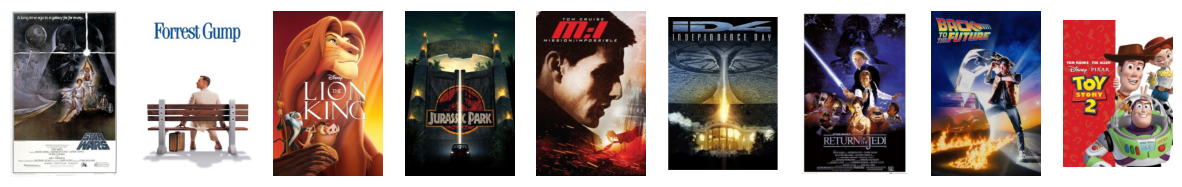

In [56]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

search = 1
similar_movies = find_similar_movies(search, X, movie_mapper, movie_inv_mapper, k=10)

# Fetch images
movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)
show_image(images)

# Purely based on genre
### One hot encoded movie x genre

In [80]:
import ast
from sklearn.metrics.pairwise import cosine_similarity

def genre_matrix(merged_df):
    # Convert string representation of list to actual list
    try:
        merged_df["genres"] = merged_df["genres"].apply(ast.literal_eval)
    except:
        pass

    # Extract only the 'name' values
    merged_df["genres_list"] = merged_df["genres"].apply(lambda x: [d["name"] for d in x] if isinstance(x, list) else [])

    genres = set(g for G in merged_df["genres_list"] for g in G)
    df = merged_df[['movieId','genres_list']]

    for g in genres:
        df[g] = df.genres_list.transform(lambda x: int(g in x))

    df = df.reset_index(drop=True)
    movie_mapper = dict(zip(list(range(df.shape[0])), df["movieId"]))
    mapper_movie = dict(zip(df["movieId"], list(range(df.shape[0]))))
    movie_genres = df.drop(columns=['genres_list','movieId'])

    cosine_sim = cosine_similarity(movie_genres, movie_genres)

    return cosine_sim, movie_mapper, mapper_movie


def genre_rec(meta, matrix, movie_mapper, mapper_movie, movie, top_n):

    idx = mapper_movie[movie]

    sim_scores = list(enumerate(matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(top_n+1)]
    similar_movies = [movie_mapper[i[0]] for i in sim_scores]

    movie_list = meta[meta['movieId'].isin(similar_movies)]['imdb_id'].values

    return movie_list

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\2579829772.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\2579829772.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\2579829772.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

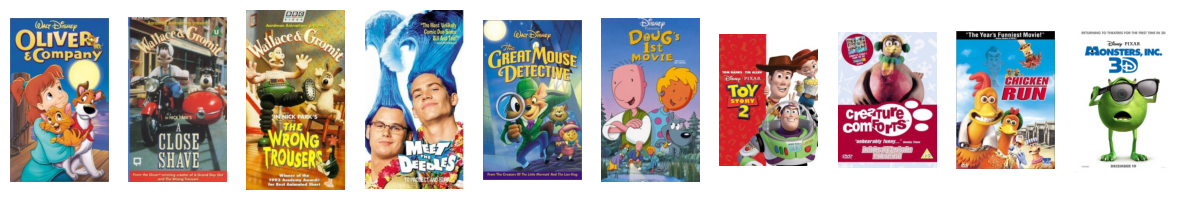

In [70]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Fetch images

cosine_sim, movie_mapper, mapper_movie = genre_matrix(merged_df)

similar_movies = genre_rec(cosine_sim, movie_mapper, mapper_movie, 1, 10)

movie_list = merged_df[merged_df['movieId'].isin(similar_movies)]['imdb_id'].values

images = image_url(movie_list)

show_image(images)

# Users with similar taste also watch

In [95]:
import pandas as pd


def similar_user_movies(user, top_k, user_movie, user_mapper, user_inv_mapper):

    similar_users = find_similar_movies(user, user_movie.T, user_mapper, user_inv_mapper, top_k)

    original_user_list = ratings[ratings['userId'] == 1]['movieId'].unique()

    similar_recommend =ratings[(ratings['userId'].isin(similar_users)) & (~ratings['movieId'].isin(original_user_list))]

    return similar_recommend



In [100]:

def nb_mean(ratings, meta):
    global_mean = ratings["rating"].mean()

    # Number of ratings per movie (n)
    movie_counts = ratings.groupby("movieId")["rating"].count()

    # Total rating sum per movie
    movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

    # C: Average number of ratings per movie
    C = movie_counts.mean()

    # Compute Bayesian Mean for each movie
    bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

    # Store results
    bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

    bayesian_mean_df = bayesian_mean_df.merge(meta[['movieId','title','imdb_id']], on='movieId',how='left')

    bayesian_mean_df = bayesian_mean_df.sort_values(by='bayesian_mean', ascending= False)

    return bayesian_mean_df



In [102]:
similar_recommend = similar_user_movies(1, 10, X, user_mapper, user_inv_mapper)
bayesian_mean_df = nb_mean(similar_recommend, merged_df)
bayesian_mean_df.head(20)['imdb_id'].values

array(['tt0848228', 'tt1345836', 'tt2015381', 'tt0080684', 'tt0076759',
       'tt0816692', 'tt0381061', 'tt1074638', 'tt1408101', 'tt2294629',
       'tt1490017', 'tt0097576', 'tt0086190', 'tt0082971', 'tt1323594',
       'tt2488496', 'tt1375666', 'tt0133093', 'tt2245084', 'tt0398286'],
      dtype=object)

# New Releases

In [104]:
def new_releases(ratings, meta, top_n, date):
    # temp = merged_df[pd.to_datetime(merged_df['release_date']) >= pd.to_datetime('2017-07-01')][['movieId','release_date']].sort_values(by='release_date',ascending=False)
    release_ratings = ratings.merge(meta[['movieId','release_date','imdb_id']], on='movieId')
    recent_release = release_ratings[pd.to_datetime(release_ratings['release_date']) >= pd.to_datetime(date)]
    recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())

    # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent_release recent_release)
    recent_release["time_weight"] = np.exp(recent_release["time_weight"])
    # Weighted sum of ratings per movie
    weighted_rating_sums = recent_release.groupby("imdb_id").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

    # Weighted count (sum of weights per movie)
    weighted_counts = recent_release.groupby("imdb_id")["time_weight"].sum()

    # Adjusted global mean with weighted ratings
    weighted_global_mean = np.sum(recent_release["rating"] * recent_release["time_weight"]) / np.sum(recent_release["time_weight"])


    # Number of ratings per movie (n)
    movie_counts = recent_release.groupby("imdb_id")["rating"].count()

    C = movie_counts.mean()

    # Compute Bayesian Mean with time-adjusted weighting
    time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

    # Store results
    time_weighted_bayesian_recent_release = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

    movie_list = list(time_weighted_bayesian_recent_release.sort_values(by='time_weighted_bayesian_mean', ascending=False)['imdb_id'].head(top_n))

    return movie_list



C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\2483699533.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\2483699533.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = np.exp(recent_release["time_weight"])
C:\Users\JaeHoBahng\AppData\Local\

Failed to retrieve image from http://img.omdbapi.com/?i=tt5540188&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt6333058&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt5635086&apikey=49b60587


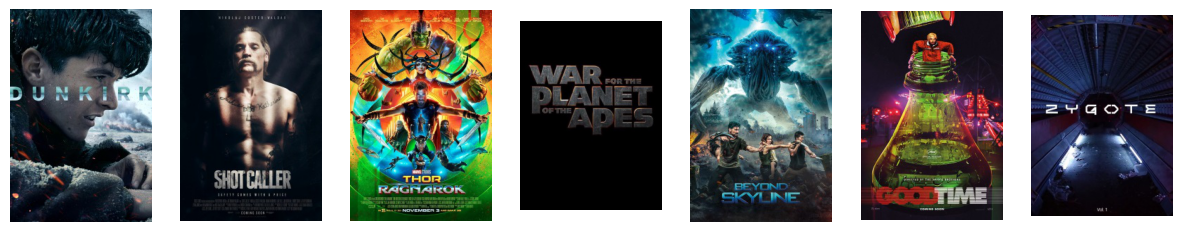

In [105]:
test = new_releases(ratings, merged_df, 10, '2017-07-01')
images = image_url(test)
show_image(images)

# Currently Trending

In [106]:
def currently_trending(ratings, meta, top_n, date):
    
    ratings["date"] = pd.to_datetime(ratings["timestamp"], unit="s").dt.date
    recent = ratings[ratings['date'] >= pd.Timestamp(date).date()]
    recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
    # Apply an exponential decay function (e.g., exp(weight) to give more importance to recent recent)
    recent["time_weight"] = np.exp(recent["time_weight"])

    # Weighted sum of ratings per movie
    weighted_rating_sums = recent.groupby("movieId").apply(lambda x: np.sum(x["rating"] * x["time_weight"]))

    # Weighted count (sum of weights per movie)
    weighted_counts = recent.groupby("movieId")["time_weight"].sum()

    # Adjusted global mean with weighted ratings
    weighted_global_mean = np.sum(recent["rating"] * recent["time_weight"]) / np.sum(recent["time_weight"])


    # Number of ratings per movie (n)
    movie_counts = recent.groupby("movieId")["rating"].count()

    C = movie_counts.mean()

    # Compute Bayesian Mean with time-adjusted weighting
    time_weighted_bayesian_mean = (weighted_rating_sums + weighted_global_mean * C) / (weighted_counts + C)

    # Store results
    time_weighted_bayesian_recent = time_weighted_bayesian_mean.reset_index().rename(columns={0: "time_weighted_bayesian_mean"})

    a = time_weighted_bayesian_recent.sort_values(by='time_weighted_bayesian_mean', ascending=False).head(top_n)
    a = a.merge(meta[['movieId','imdb_id']],  on='movieId',how='left')
    movie_list = a['imdb_id'].values 

    return movie_list



C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\488419814.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\488419814.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = np.exp(recent["time_weight"])
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_10352\488419814.py:10: DeprecationWarning: 

Failed to retrieve image from http://img.omdbapi.com/?i=tt3718778&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=nan&apikey=49b60587


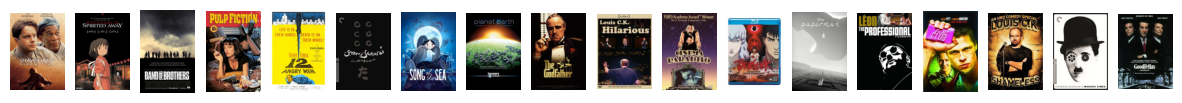

In [107]:
movie_list = currently_trending(ratings, merged_df, 10, '2017-07-01')
images = image_url(movie_list)
show_image(images)

# Best alltime

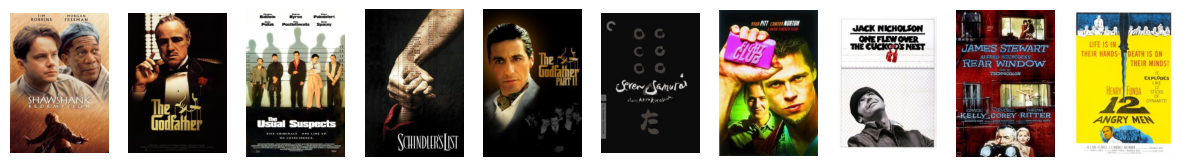

In [65]:
import pandas as pd

def best_alltime(ratings, meta, top_n):

    # Global mean rating (m)
    global_mean = ratings["rating"].mean()

    # Number of ratings per movie (n)
    movie_counts = ratings.groupby("movieId")["rating"].count()

    # Total rating sum per movie
    movie_rating_sums = ratings.groupby("movieId")["rating"].sum()

    # C: Average number of ratings per movie
    C = movie_counts.mean()

    # Compute Bayesian Mean for each movie
    bayesian_mean_ratings = (movie_rating_sums + global_mean * C) / (movie_counts + C)

    # Store results
    bayesian_mean_df = bayesian_mean_ratings.reset_index().rename(columns={"rating": "bayesian_mean"})

    a = bayesian_mean_df.sort_values(by='bayesian_mean', ascending=False).head(top_n)
    a = a.merge(meta[['movieId','imdb_id']],  on='movieId',how='left')
    movie_list = a['imdb_id'].values 

    return movie_list

images_list = best_alltime(ratings, merged_df, 10)
images = image_url(images_list)
show_image(images)

# Multiple Recommendations for one user

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)

from src.recommend.utils.read import read_files

folder_path = "./data/kaggle_movies"
dataframes = read_files(folder_path)

credits = dataframes['credits']
keywords = dataframes['keywords']
links = dataframes['links']
links_small = dataframes['links_small']
movies_metadata = dataframes['movies_metadata']
ratings = dataframes['ratings']
ratings_small = dataframes['ratings_small']

movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')
meta = movies_metadata.merge(links, left_on='id', right_on='tmdbId', how='left')
meta = meta[~meta['id'].isnull()]
keywords = keywords[keywords['keywords'] != '[]']

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\utils\read.py:12: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[df_name] = pd.read_csv(file_path)


In [2]:
from src.recommend.rec import recommendation

rec = recommendation(1, 20, meta, ratings)

## What movies did user 1 watch?

In [3]:
watched_movies = rec.user_watched(20)
meta[meta['movieId'].isin(watched_movies)]['title']

108                                        Braveheart
144                            The Basketball Diaries
835                                     The Godfather
1181                           The Godfather: Part II
1204                               Dead Poets Society
1863                               The Breakfast Club
2807                         Ferris Bueller's Day Off
2848                                       Fight Club
4104                                          Memento
10138                                   Batman Begins
12501                                 The Dark Knight
12608                                        Iron Man
13669                                       Star Trek
13919          Harry Potter and the Half-Blood Prince
14586                                 Sherlock Holmes
16160    Harry Potter and the Deathly Hallows: Part 1
18280                                The Hunger Games
18294              Sherlock Holmes: A Game of Shadows
20227               The Hobb

## Recommend Movies with Similar Genres from watched movies

In [4]:
genre_similarity_matrix, movie_mapper, mapper_movie = rec.genre_matrix()

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[g] = df.genres_list.transform(lambda x: int(g in x))
c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:101: SettingWithCopyWarni

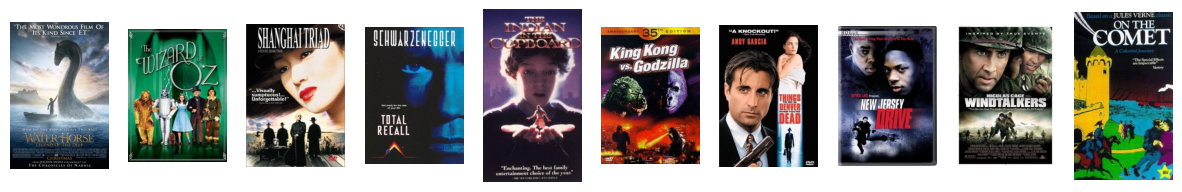

In [5]:
import random
from src.recommend.utils.image import image_url, show_image

genre_recommendation = []
for i in watched_movies:
    similar_movies = rec.genre_rec(genre_similarity_matrix, movie_mapper, mapper_movie, i)
    genre_recommendation.extend(similar_movies)

random.shuffle(genre_recommendation)

images = image_url(genre_recommendation[:10])
show_image(images)

# Users with similar taste also watch

In [6]:
X = rec.create_X()


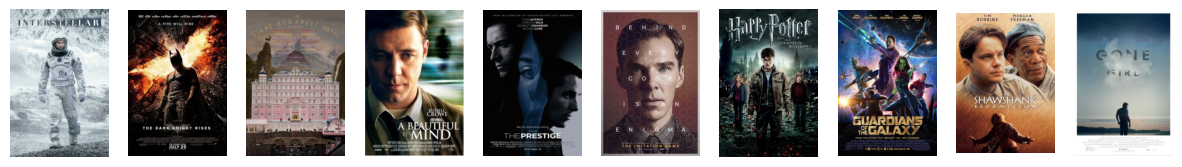

In [7]:
from src.recommend.utils.image import image_url, show_image

similar_recommend = rec.similar_user_movies(X)
bayesian_mean_df = rec.nb_mean(similar_recommend)
movie_list = bayesian_mean_df['imdb_id'].values

images = image_url(movie_list[:10])
show_image(images)

# Keyword based Recommendation on movies Watched

In [ ]:
keyword_similarity_matrix = rec.keyword_similarity(keywords)
watched_movies = rec.user_watched(20)

array([73017, 91500, 98809, 91542,   147,  4226,  1968, 69844, 81834,
       58559, 33794, 99114,  2959,  2918,  1246,  1221,   110,   858,
       59315, 68358], dtype=int64)

Failed to retrieve image from http://img.omdbapi.com/?i=tt5284240&apikey=49b60587


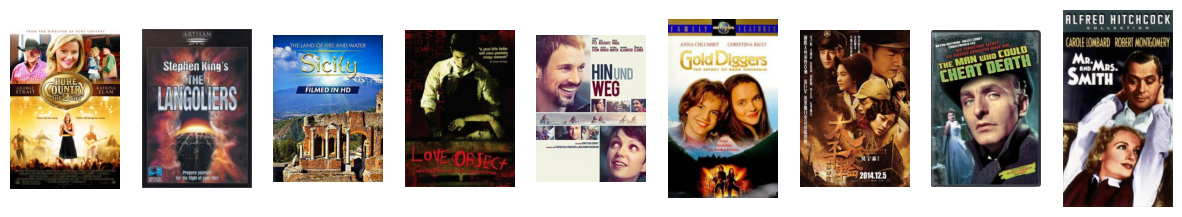

In [10]:
watched_movies = rec.user_watched(20)
# meta[meta['movieId'].isin(watched_movies)]['title']

keyword_recommendation = []
for i in watched_movies:
    similar_movies = rec.keyword_rec(keyword_similarity_matrix, keywords, i)
    keyword_recommendation.extend(similar_movies)

random.shuffle(keyword_recommendation)

images = image_url(keyword_recommendation[:10])
show_image(images)

# New Release

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = (recent_release["timestamp"] - recent_release["timestamp"].min()) / (recent_release["timestamp"].max() - recent_release["timestamp"].min())
c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_release["time_weight"] = np.exp(recent_release["t

Failed to retrieve image from http://img.omdbapi.com/?i=tt5540188&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt6333058&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt5635086&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt4536768&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt1724597&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=tt6794380&apikey=49b60587


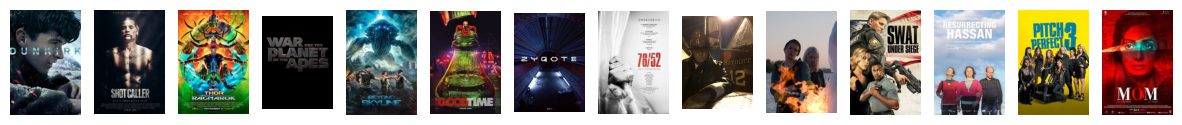

In [11]:
test = rec.new_releases('2017-07-01')
images = image_url(test)
show_image(images)

# Currently Trending

c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = (recent["timestamp"] - recent["timestamp"].min()) / (recent["timestamp"].max() - recent["timestamp"].min())
c:\Users\JaeHoBahng\Desktop\US_Job\Portfolio\Recommendation\movielens\src\recommend\rec.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent["time_weight"] = np.exp(recent["time_weight"])


Failed to retrieve image from http://img.omdbapi.com/?i=tt3718778&apikey=49b60587
Failed to retrieve image from http://img.omdbapi.com/?i=nan&apikey=49b60587


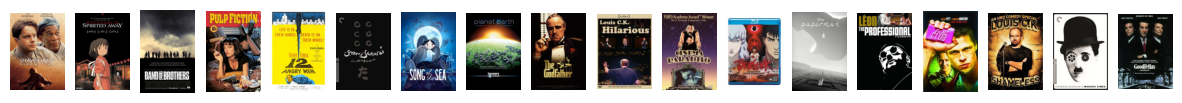

In [12]:
movie_list = rec.currently_trending('2017-07-01')
images = image_url(movie_list)
show_image(images)

# Best of Alltime

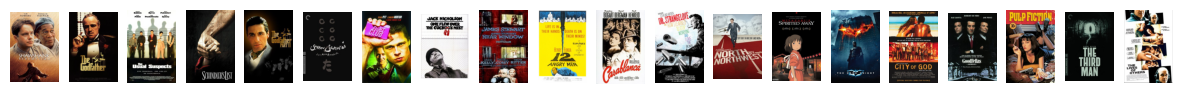

In [13]:
images_list = rec.best_alltime()
images = image_url(images_list)
show_image(images)